**Synthetic Data Generation Using Bayesian Method Based on Distribution**

**1. Import Dataset**

In [1]:
#Download dataset from: https://drive.google.com/file/d/1xu_xdVySieNg1vjqPskRyGSARA-YDK1N/view?usp=sharing
!gdown --id 1xu_xdVySieNg1vjqPskRyGSARA-YDK1N

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1xu_xdVySieNg1vjqPskRyGSARA-YDK1N
To: /content/database.txt
100% 1.90M/1.90M [00:00<00:00, 164MB/s]


In [2]:
import pandas as pd
import numpy as np

import pymc as pm
import arviz as az
pd.options.display.float_format = '{:.2f}'.format
import scipy
# import blackjax
# import numpyro
# import posterior

import matplotlib.pyplot  as plt
import seaborn as sns
sns.set()

import scipy.io
import scipy.optimize

from matplotlib.lines import Line2D
from pymc.sampling.jax import sample_blackjax_nuts, sample_numpyro_nuts
from scipy.stats import multivariate_normal
import matplotlib.cm as cm
from matplotlib.lines import Line2D

In [3]:
file_path = 'database.txt'
datt = pd.read_fwf(file_path, header=None)
datt

,0,1,2,3,4,5,6,7,8,9,...,979,980,981,982,983,984,985,986,987,988
0,1.00,1.00,1.00,1.00,0.97,0.97,0.96,0.96,0.96,0.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.99,0.99,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.00,1.00,0.99,0.99,0.99,0.98,0.98,0.94,0.94,0.92,...,0.98,0.99,0.99,1.00,1.00,NaN,NaN,NaN,NaN,NaN
3,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.98,0.98,0.98,...,0.95,0.95,0.96,0.96,0.97,0.98,0.98,0.99,1.00,1.00
4,1.00,1.00,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,1.00,1.00,0.99,0.98,0.98,0.98,0.97,0.96,0.96,0.95,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
373,1.00,0.99,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
374,1.00,1.00,1.00,0.99,0.99,0.95,0.95,0.95,0.94,0.94,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
375,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.98,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The dataset is time series data comes from leaf shape and have different size of series, when read dataset as Data Frame it shows blank space that is not represent the leaf shape filling as NaN or missing value automatically by Pandas Data Frame. 

We can't handle this different sizes with any handling missing values method, since it will change the shape of leaf and data distribution around it. 

Thus, more observing this dataset is needed to understand what kind approach we needed

In [ ]:
datt.shape

(377, 989)

It shows, the dataset contains 377 rows which represent number of lines draw around from the base of the leaf to the edge of the leaf and mapping the leaf of shape itself

Column represent the length of of every line that draw form the base of the leaf to the edge of the leaf. 989 columns represent the longest line from the base of the leaf to the edge of the leaf. And every line not have same length since leaf shape is not square. It caused when a line reach the edge of the leaf but the length itsel is less than the longest line, it will consider as blank space cause there is nothing there after the edge of the line.

It causes the different sizes of time series data, When we read this data through Data Frame which come in tabular format, Pandas library then will automatically considering this blank space in different sizes time series as missing value.

In [ ]:
print(datt.values)

[[1.     1.     0.9957 ...    nan    nan    nan]
 [1.     1.     1.     ...    nan    nan    nan]
 [1.     0.9962 0.9925 ...    nan    nan    nan]
 ...
 [1.     1.     1.     ...    nan    nan    nan]
 [1.     0.9953 1.     ...    nan    nan    nan]
 [1.     0.9873 0.9831 ...    nan    nan    nan]]


Draw the shape of leaf to have better view about the dataset

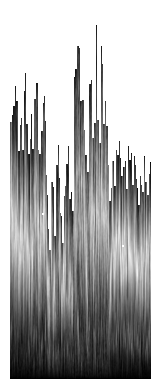

In [ ]:
# convert values equal to 0 to NaN so it will not read when we plotting the leaf shape
dff = datt.replace(0, np.nan)
df_flipped = pd.DataFrame(np.flip(dff.values, axis=1)).transpose()

# create plot
plt.imshow(df_flipped, cmap='binary', vmin=0, vmax=1)
plt.axis('off')

plt.show()


It can be seen that the length of edge for every line data point is different. This is the main causes the dataset have different sizes of time series data

show data distribution of leaf shape

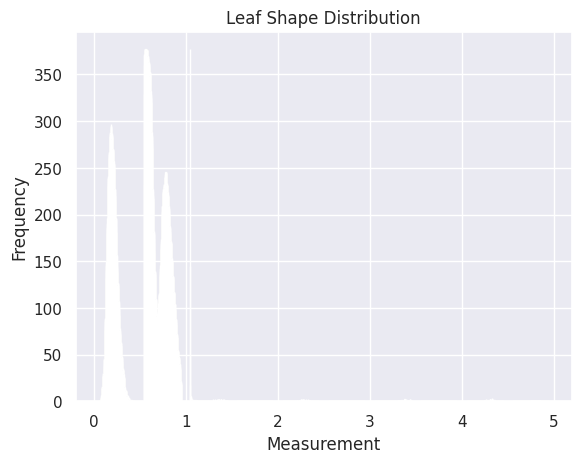

In [4]:
data = datt.values

plt.hist(data)
plt.title('Leaf Shape Distribution')
plt.xlabel('Measurement')
plt.ylabel('Frequency')
plt.show()

Show data distribution with gaussian interference

([<matplotlib.axis.YTick at 0x7f56f918f880>], [Text(0, 0, '0')])

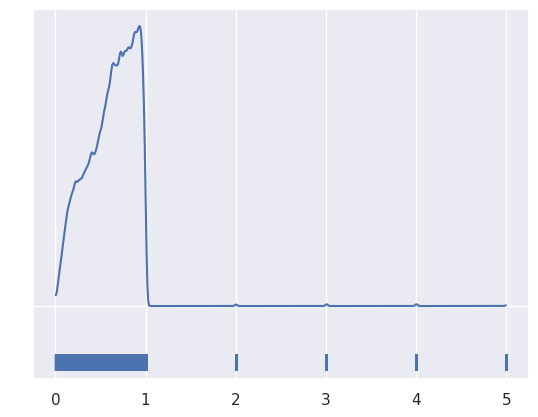

In [ ]:
%matplotlib inline

az.plot_kde(data, rug=True)
plt.yticks([0], alpha=0)

The KDE plot of leaf shape shows a Gaussian-like distribution, It shows that most of the value in dataset is around 0 to 1

Shows the number of blank space that consider as missing values on Data Frame

In [ ]:
print("Number of NaN values:", datt.isna().sum().sum())

Number of NaN values: 101447


we fill every blank space with the edge for every line data point, so the shape itself will not change. Stretching this edge until it fill all data frame is fillfull

In [4]:
data2 = datt.transpose()
data2 = data2.ffill()

In [5]:
data2 = data2.transpose()
data2

,0,1,2,3,4,5,6,7,8,9,...,979,980,981,982,983,984,985,986,987,988
0,1.00,1.00,1.00,1.00,0.97,0.97,0.96,0.96,0.96,0.96,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.99,0.99,0.99,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,1.00,1.00,0.99,0.99,0.99,0.98,0.98,0.94,0.94,0.92,...,0.98,0.99,0.99,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,1.00,1.00,1.00,0.99,0.99,0.98,0.98,0.98,0.98,0.98,...,0.95,0.95,0.96,0.96,0.97,0.98,0.98,0.99,1.00,1.00
4,1.00,1.00,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,1.00,1.00,0.99,0.98,0.98,0.98,0.97,0.96,0.96,0.95,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
373,1.00,0.99,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
374,1.00,1.00,1.00,0.99,0.99,0.95,0.95,0.95,0.94,0.94,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00
375,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.99,0.99,0.98,...,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00,5.00


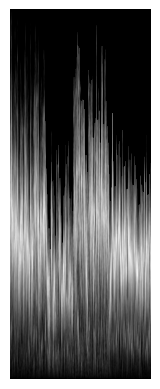

In [6]:
# convert values equal to 0 to NaN
df2 = data2.values
df_flipped2 = pd.DataFrame(np.flip(df2, axis=1)).transpose()

# create plot
plt.imshow(df_flipped2, cmap='binary', vmin=0, vmax=1)
plt.axis('off')

plt.show()

After we stretching the edge of the shape to fill dataframe, it shows there is no change in the leaf shape

Now we check the data distribution after we stretching every edge of the leaf shape

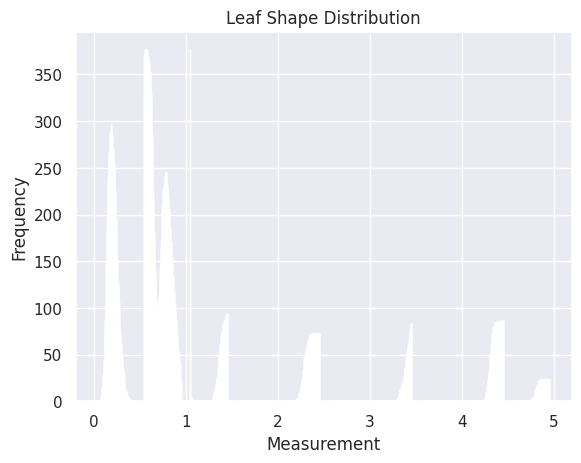

In [8]:
# data2 = a_nonzero.values

plt.hist(df2)
plt.title('Leaf Shape Distribution')
plt.xlabel('Measurement')
plt.ylabel('Frequency')
plt.show()

it can be seen that frequnecy of several value is increase cause we stretch the edge of shape and the frequncy of edge value increase significant

Gaussian interferance on data distribution

([<matplotlib.axis.YTick at 0x7f374a73dde0>], [Text(0, 0, '0')])

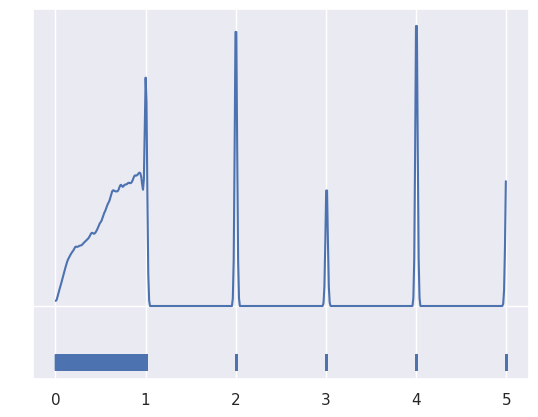

In [ ]:
%matplotlib inline

az.plot_kde(df2, rug=True)
plt.yticks([0], alpha=0)

It can be seen that value representing the edge value for every line in the leaf. Since we stretching the edge, it shows that value of the edge is increase not just 0 to 1 anymore.

Let's assume that a Gaussian distribution is a proper description of the leaf shape time series data. Since we do not know the mean or the standard deviation, we must set priors for both of them.

In [ ]:
print('Running on PyMC v{}'.format(pm.__version__))

Running on PyMC v5.1.2


## Model

We will perform Gaussian inferences on the leaf shape time series data. Here's some of the modelling choices that go into this.

Choices for leaf shape likelihood function:

The leaf shape data is modelled as a linear combination of the independent variables. We assume that the leaf shape time series data is going to be normally distributed around the linear combination of independent variables with the same variance around the expected value.

That is how we proceed below:

In [7]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=989) #Use any prior knowledge 
    sigma = pm.HalfNormal('sigma', sigma=10) 
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=df2)
    
    trace = pm.sample(1000, tune=1000)
    # trace = pm.sample(1000, tune=1000, return_inferencedata=False)

We instantiate the Models in PyMC5 like above.

model specifications in PyMC5 are wrapped in a with-statement.
Choices of priors:

- mu, mean of a population. Normal distribution. We do not know the possible values of mean, we can set priors reflecting our ignorance. From experience before we know that line of leaf shape length can not be lower than 0 or higher than 989, thus we set the boundaries of the uniform distribution to be 0 and 989. 

- sigma, standard deviation of a population. Can only be positive, therefore use HalfNormal distribution

Choices for leaf shape likelihood function:

- y is an observed variable representing the data that comes from a Normal distribution with the parameters mu and sigma.

- draw 1000 posterior samples using NUTS sampling

In the end, "y" specifies the likelihood. This is the way in which we tell PyMC5 that we want to condition for the unknown on the knows (data).

In [10]:
with model:
    print(trace)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data


It can be seen, using PyMC5, we can write the model as follows:

Running MCMC: on sampling from the prior distribution, evaluate the likelihood of the sampled parameter, then (in the next cell) plot, what is the likelihood of a given sampled parameter.

array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

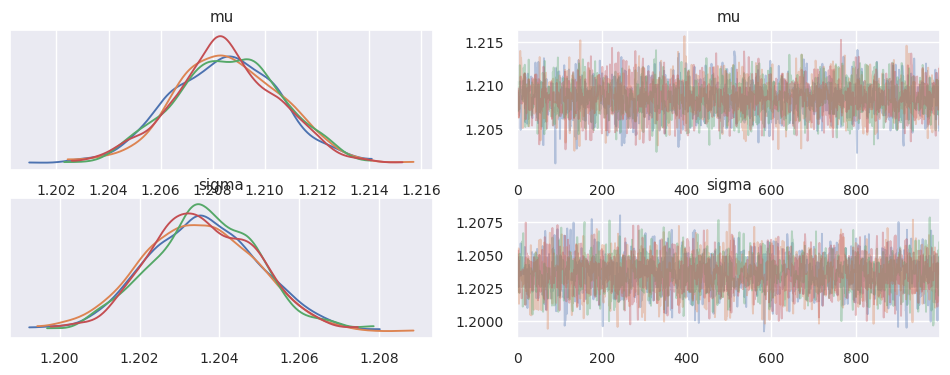

In [13]:
az.plot_trace(trace, compact=False)

From image above, on the left, we have a KDE plot, – for each parameter value on the x-axis we get a probability on the y-axis that tells us how likely that parameter value is.

On the right, we get the individual sampled values at each step during the sampling. From the trace plot, we can visually get the plausible values from the posterior.

The above plot has one row for each parameter. For this model, the posterior is bi-dimensional, and so the above figure is showing the marginal distributions of each parameter.

There are a couple of things to see here.

Our sampling chains for the individual parameters (left side) seem well converged and stationary (there are no large drifts or other odd patterns).

The maximum posterior estimate of each variable (the peak in the left side distributions) is very close to the true parameters.

We can plot a joint distributions as plot pair (figure below) of parameters. We don't see any correlation between these two parameters. This means we probably do not have collinearity in the model which is this is good.

array([[<Axes: >, None],
       [<Axes: xlabel='mu', ylabel='sigma'>, <Axes: >]], dtype=object)

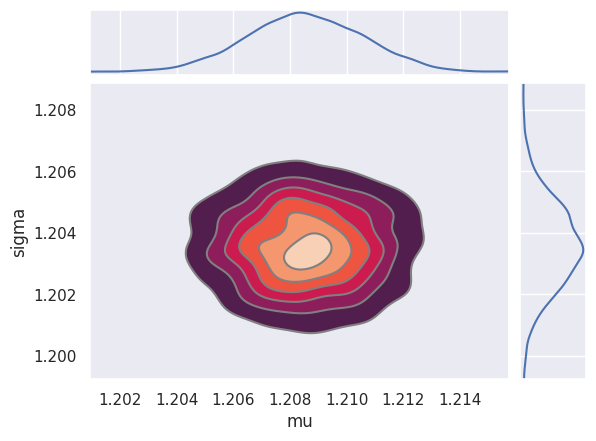

In [19]:
az.plot_pair(trace, kind='kde', marginals=True)

In [8]:
pd.set_option('display.float_format', '{:.8f}'.format)

We can also have a detailed summary of the posterior distribution for each parameter

In [25]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1.20900000,0.00200000,1.20500000,1.21200000,0.00000000,0.00000000,4066.00000000,2836.00000000,1.00000000
sigma,1.20400000,0.00100000,1.20100000,1.20600000,0.00000000,0.00000000,4037.00000000,2866.00000000,1.00000000


**HDI: Highest Density Interval** - All points within this interval have a higher probability density than points outside the interval.

hdi_3% and hdi_97% one representing the left end of the interval (the value below which 3% of the posterior falls) and one representing the right end of the interval (the value above which 3% of the posterior falls)


We can also see the above summay visually by generating a plot with the mean and HPD of a distribution.

We get the mean, standard deviation (sd), and 94% HPD interval (hpd 3% and hpd 97%). we can use these numbers to interpret and report the results of a Bayesian inference below.

array([<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'sigma'}>],
      dtype=object)

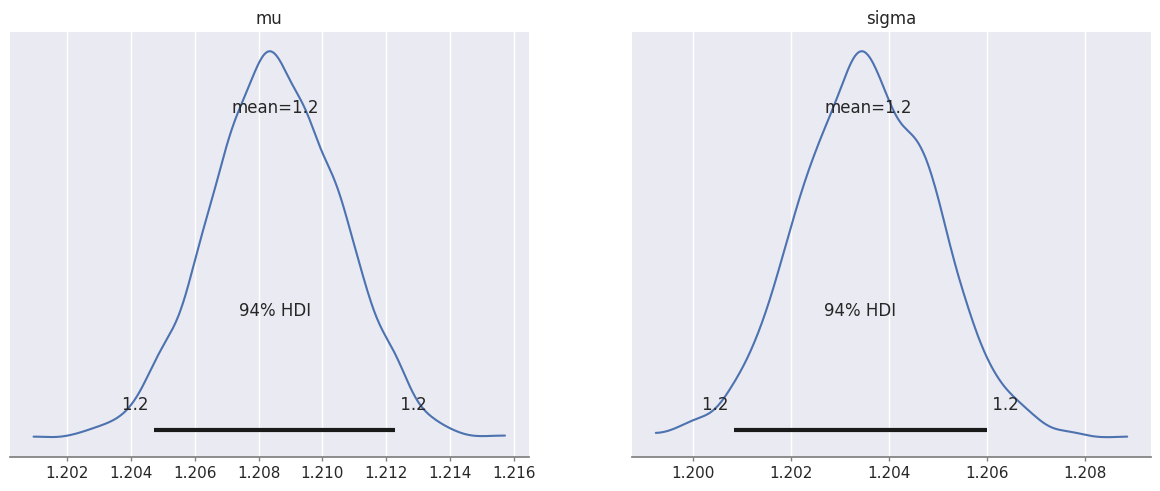

In [26]:
az.plot_posterior(trace)

It can be seen, unlike Frequentist statistics, in Bayesian statistics, we get the entire distribution of the values.

Every time ArviZ computes and reports a HPD, it will use, by default, a value of 94%. HPD intervals are not the same as confidence intervals. There is 94% probability the belief is around 1.20 for the mean leaf shape

Now, we use bar plot of the autocorrelation function (ACF) for a sequence of time series data.

The ACF plots are helpful as a convergence diagnostic for posteriors from MCMC samples which display autocorrelation.

array([[<Axes: title={'center': 'mu\n0'}>,
        <Axes: title={'center': 'mu\n1'}>,
        <Axes: title={'center': 'mu\n2'}>,
        <Axes: title={'center': 'mu\n3'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>]], dtype=object)

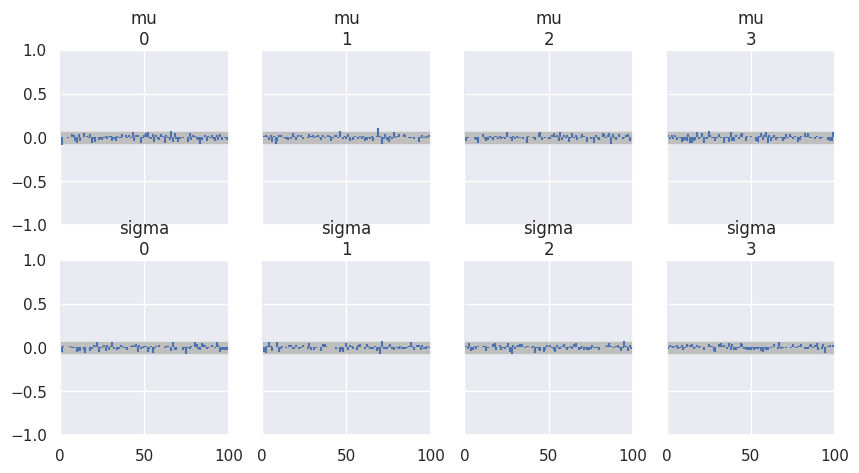

In [27]:
pm.plots.plot_autocorr(trace, figsize=(10,5))

It can be seen that all the blue line is around 0 which mean it is uncorrelated or random data. This means we probably do not have collinearity in the model which is this is good.

We can also verify the convergence of the chains formally using the Gelman Rubin test. Values close to 1.0 mean convergence.

(tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain. If convergence has been achieved, the between-chain and within-chain variances should be identical.


In [30]:
#pm.gelman_rubin(trace_g)
az.rhat(trace)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    mu       float64 1.003
    sigma    float64 1.002

It can be seen that the result value (mu & sigma) are around 1. Now we will plot it using BFMI energy plot

**Bayesian fraction of missing information (BFMI)**

BFMI quantifies how well momentum resampling matches the marginal energy distribution.

<Axes: >

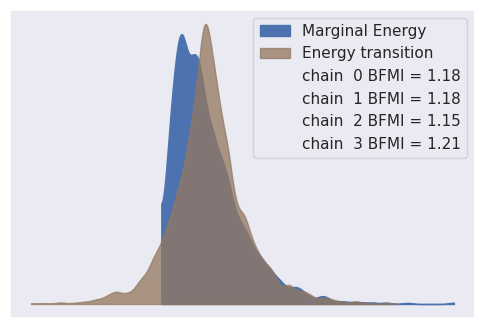

In [9]:
bfmi = pm.bfmi(trace)
pm.plot_energy(trace, figsize=(6,4))

Our model has converged well and looks good.

## Evaluate Model

**Posterior Predictive Checks**

Posterior predictive checks (PPCs) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Now that we have computed the posterior, we are going to illustrate how to use the simulation results to derive predictions.

The following function will randomly draw 1000 samples with 4 chains of parameters from the trace. Then, for each sample, it will draw leaf shape time series data (377,989) random numbers from a normal distribution specified by the values of mu and sigma in that sample.

In [10]:
ppc = pm.sample_posterior_predictive(trace, model=model)

In [11]:
ppc2 = ppc.posterior_predictive['y']
np.asarray(ppc2).shape

(4, 1000, 377, 989)

Now, ppc contains 1000 generated data sets in 4 chains (containing 377x989 samples each), each using a different parameter setting from the posterior.

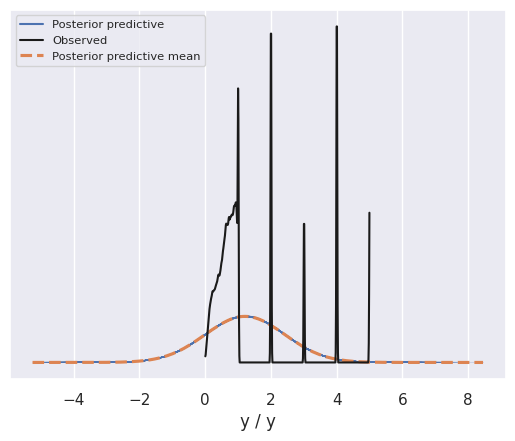

In [14]:
az.plot_ppc(ppc, num_pp_samples=100);

It can be seen mean is very close to leaf shape mean

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

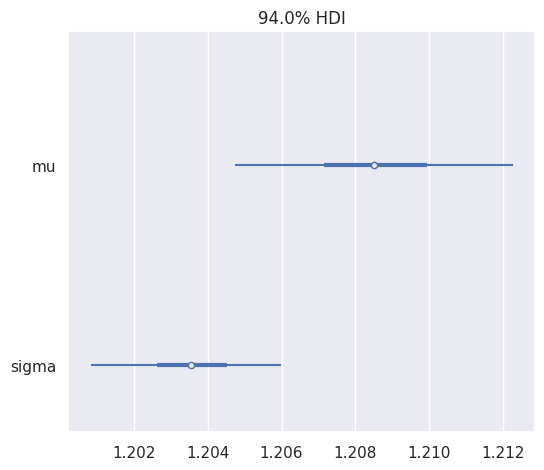

In [52]:
az.plot_forest(trace, combined=True)

## extract features

In [138]:
df10 = trace.posterior.to_dataframe()
df10

mu      sigma
chain draw                      
0     0    1.20802366 1.20377711
      1    1.20776375 1.20388605
      2    1.20962758 1.20282216
      3    1.20871262 1.20408558
      4    1.21046899 1.20183500
...               ...        ...
3     995  1.20832925 1.20260356
      996  1.20929669 1.20195188
      997  1.20929669 1.20195188
      998  1.20970861 1.20575123
      999  1.20855233 1.20585195

[4000 rows x 2 columns]

we take posterior predictive value as our feature

In [15]:
ppc2

<xarray.DataArray 'y' (chain: 4, draw: 1000, y_dim_2: 377, y_dim_3: 989)>
array([[[[ 2.46561126e+00,  1.14974546e+00,  1.54077336e+00, ...,
           1.28710050e+00,  6.90660067e-01,  1.45300027e+00],
         [ 2.26840451e-01,  1.51880935e+00,  1.41944060e+00, ...,
          -2.25194850e+00,  1.11005642e+00,  8.75458553e-01],
         [ 2.78610784e+00,  2.69948858e+00,  1.69011789e+00, ...,
           1.45705989e+00, -2.60661329e-01,  2.41243875e+00],
         ...,
         [-2.59368882e-01,  1.95635868e+00, -1.67606572e-01, ...,
           7.60371103e-01,  1.84051260e+00,  1.69124686e+00],
         [ 9.71890898e-01, -1.12913716e+00,  1.65977277e+00, ...,
           4.05519652e-02,  1.04890314e+00,  1.92369768e-01],
         [ 8.55673815e-01,  1.28595681e+00,  1.88522136e+00, ...,
           1.53316013e+00,  4.86390996e-01,  1.37838312e+00]],

        [[ 4.21476900e-01,  1.81953981e+00,  6.02490644e-01, ...,
           1.22620465e-02,  3.51033864e+00, -1.35887085e-01],
         [ 2.17163213e+00,  2.19885143e-01, -2.43115418e-01, ...,
           2.01131750e+00,  1.88669441e+00, -2.88813836e-01],
         [ 3.20719560e+00,  1.26467737e+00, -4.10000322e-01, ...,
           9.06268777e-01,  4.65714570e-01,  3.41244085e+00],
...
         [ 1.60952539e+00,  1.19356908e+00,  1.07112129e+00, ...,
           2.54979587e-01,  8.91053268e-01, -2.95903327e-01],
         [ 8.34647330e-01,  1.70928067e+00,  2.22044299e+00, ...,
           2.59427559e+00,  2.33223494e+00,  3.11224442e+00],
         [-6.39292317e-02,  1.85990198e+00, -1.17949698e+00, ...,
          -1.38624355e-01,  2.06354719e+00,  5.95016608e-01]],

        [[ 5.60671935e-01,  8.60664040e-01,  1.77524328e+00, ...,
           1.85726142e+00, -1.13418647e+00,  1.72284849e+00],
         [ 1.61965048e+00, -9.61717366e-01,  2.50827023e+00, ...,
           4.24424489e-01,  1.53853329e+00,  2.52895167e+00],
         [ 8.01582701e-01,  7.30319204e-01,  1.32130863e-01, ...,
           6.92783824e-01, -3.11421322e-02,  1.39708774e+00],
         ...,
         [ 1.42875417e-02,  2.34140560e+00,  1.12498806e+00, ...,
           1.63189683e+00,  2.27433101e+00,  1.98054471e+00],
         [ 1.82798524e+00,  1.08431689e+00,  1.02714514e+00, ...,
           1.91068094e+00,  1.86265017e+00,  1.34481885e+00],
         [ 1.94900774e+00,  3.04126518e+00, -1.03006941e+00, ...,
           7.83464689e-01,  1.27952713e+00,  1.38121719e+00]]]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * y_dim_2  (y_dim_2) int64 0 1 2 3 4 5 6 7 ... 369 370 371 372 373 374 375 376
  * y_dim_3  (y_dim_3) int64 0 1 2 3 4 5 6 7 ... 981 982 983 984 985 986 987 988

it shows posterior predictive have 4d array, we reshape it to 2d array for dataframe. we calculate 4x1000x989 as data distribution and 377 as the line from leaf shape

In [16]:
b = 4*1000*989
b

3956000

In [17]:
new = ppc2.values.reshape(377, b)
new

array([[ 2.46561126,  1.14974546,  1.54077336, ...,  1.81617583,
         1.70951174,  1.34479797],
       [ 0.07976395,  0.89872131,  2.65742114, ...,  1.8564152 ,
        -0.08965306,  0.216903  ],
       [ 0.58161587,  2.04943442,  2.00927359, ...,  2.0074115 ,
        -0.49634543,  3.02076446],
       ...,
       [-0.67161429, -2.06437868,  0.7885764 , ...,  1.80874053,
         3.61378237,  1.38207981],
       [ 0.76652882,  0.01942492,  0.18961551, ...,  0.84031172,
         1.62626022,  1.20512657],
       [ 1.26485832,  0.26497755,  3.53419216, ...,  0.78346469,
         1.27952713,  1.38121719]])

In [18]:
new.shape

(377, 3956000)

Create features from the posterior predictive distribution of the Bayesian model. Commonly used features are mean, median, standard deviation, and a measure of the distribution's tail (e.g., 95% Highest Posterior Density Interval, HPDI).

In [19]:
mean = np.mean(new, axis=1)
median = np.median(new, axis=1)
std = np.std(new, axis=1)

# 95% HPDI (Highest Posterior Density Interval)
neww = new.transpose() #transpose it to calculate hpdi
hpdi = az.hdi(neww, hdi_prob=0.95)
hh = hpdi.transpose() #trancspose it again to original


<ipython-input-19-c69bfe456f2c>:7: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hpdi = az.hdi(neww, hdi_prob=0.95)


In [ ]:
# hh[0]

In [22]:
#take hh[1] as hpdi feature as we just want positive value on our features
hh[1]

array([3.56398331, 3.55425257, 3.55509587, 3.56506966, 3.56813272,
       3.57178037, 3.55802251, 3.59176754, 3.56806177, 3.55499401,
       3.55752924, 3.56775064, 3.55958104, 3.57187575, 3.565478  ,
       3.57333381, 3.56160807, 3.55244703, 3.5713714 , 3.56210224,
       3.5662726 , 3.56852092, 3.57719435, 3.56603373, 3.57994893,
       3.57637697, 3.57403928, 3.56902154, 3.56142617, 3.5707413 ,
       3.55871519, 3.54832629, 3.5718841 , 3.57922673, 3.57503235,
       3.5708676 , 3.55983562, 3.57215974, 3.56993863, 3.56776401,
       3.5566058 , 3.5628336 , 3.56710193, 3.55822249, 3.58630839,
       3.57577331, 3.5635189 , 3.56256424, 3.5604406 , 3.56039062,
       3.5677506 , 3.57375228, 3.57199534, 3.56750411, 3.55951147,
       3.57143999, 3.5710664 , 3.56996111, 3.57143752, 3.57802441,
       3.55564484, 3.57874311, 3.55707396, 3.57339877, 3.57997257,
       3.56344682, 3.56721031, 3.56934066, 3.56920769, 3.58275957,
       3.56154927, 3.56841182, 3.57947742, 3.56381934, 3.55620

In [23]:
features = np.array([mean, median, std, hh[1]])
df3 = pd.DataFrame(data = features,index = ['mean', 'median', 'std', 'hdi']).T
df3

,mean,median,std,hdi
0,1.20831269,1.20890122,1.20340955,3.56398331
1,1.20798000,1.20789784,1.20237318,3.55425257
2,1.20801204,1.20797287,1.20305406,3.55509587
3,1.20822167,1.20809699,1.20322997,3.56506966
4,1.20737233,1.20717044,1.20370275,3.56813272
...,...,...,...,...
372,1.20716667,1.20729781,1.20393550,3.57039609
373,1.20822777,1.20754412,1.20229557,3.56565348
374,1.20981709,1.20898102,1.20450244,3.57322820
375,1.20650705,1.20679460,1.20428788,3.56562639


**Data Labelling**

now create data label using mean as the parameter

In [185]:
df3['y'] = df3['mean'] < df2.mean()
df3

,mean,median,std,hdi,y
0,1.20831269,1.20890122,1.20340955,3.56398331,True
1,1.20798000,1.20789784,1.20237318,3.55425257,True
2,1.20801204,1.20797287,1.20305406,3.55509587,True
3,1.20822167,1.20809699,1.20322997,3.56506966,True
4,1.20737233,1.20717044,1.20370275,3.56813272,True
...,...,...,...,...,...
372,1.20716667,1.20729781,1.20393550,3.57039609,True
373,1.20822777,1.20754412,1.20229557,3.56565348,True
374,1.20981709,1.20898102,1.20450244,3.57322820,False
375,1.20650705,1.20679460,1.20428788,3.56562639,True


In [ ]:
# df3['y'] = np.mean(df3['hdi']) < df3['hdi']
# df3

In [186]:
print(np.sum(df3['y'] == True))

205


In [187]:
print(np.sum(df3['y'] == False))

172


It shows 191 data labeled as True and 186 data as False

##Validating Data Augmentation

We have to make sure that data we augmented is similiar with the original data. Thus, we will use confusion matrix to calculate the precision and recall of our data augmentation. And since we use mean features for label parameter, so we use mean value of leaf shape to validate our data label

In [49]:
np.mean(df2)

1.2085408463925458

we create label from original data leaf shape use mean as parameter, and we know that mean value of our original data is 1.208. We use this value as our parameter to create label

In [188]:
row_means = np.mean(df2, axis=1) < df2.mean()

feature2 = np.array([row_means])
df0 = pd.DataFrame(data = feature2,index = ['original_mean']).T

# Print row means
print(df0)

     original_mean
0             True
1             True
2             True
3             True
4             True
..             ...
372          False
373          False
374          False
375          False
376          False

[377 rows x 1 columns]


In [189]:
print(np.sum(df0['original_mean'] == True))

214


In [178]:
df_confusion = pd.crosstab(df3['y'], df0['original_mean'])

In [179]:
df_confusion

original_mean,False,True
y,,
False,5,13
True,157,202


In [180]:
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

[[ 78  85]
 [ 94 120]]


Text(0.5, 1.0, 'Data augmentation confusion matrix')

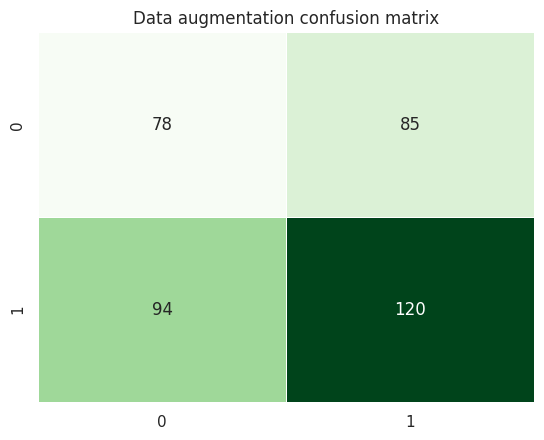

In [190]:
conf_m = metrics.confusion_matrix(df0['original_mean'], df3['y'])
print(conf_m)
sns.heatmap(conf_m, annot = True,  linewidths=.5, cbar =None, fmt='g', cmap='Greens')
plt.title('Data augmentation confusion matrix')

In [191]:
precision = precision_score(df0['original_mean'], df3['y'])
recall = recall_score(df0['original_mean'], df3['y'])

In [192]:
precision

0.5853658536585366

In [193]:
recall

0.5607476635514018

The result show precision 58% and recall 56%, this happen cause we strecth the edge of leaf shape create value of the edge increase signicant. Thus, the data became bias when we perform bayesian model on it. Bayesian fail to generate close value for every line in original data since it just generating mean and standar deviation based on mean value of leaf shape time series data

save data augmentation to csv

In [ ]:
df3.to_csv('df_synthetic_data.csv')

done!